#Educação em geofísica
Material didático - algoritmos para aulas de geofísica
##Gravimetria - Obtendo a Anomalia Bouguer

Citação: Szameitat, L.S.A., Bongiolo, A.B.S. 2023. Educação em geofísica: recursos computacionais para tratamento de dados magnetométricos e gravimétricos em sala de aula. Boletim Paranaense de Geociências.



Instalação de bibliotecas do projeto Fatiando a Terra https://www.fatiando.org/index.html

In [89]:
!pip install verde

In [90]:
!pip install harmonica

Importar bibliotecas

In [91]:
import numpy as np
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt
import pandas as pd

##Arquivo de entrada
Carregar arquivo de dados no ambiente. O arquivo deve ser do tipo csv, e conter as seguintes colunas:
LESTE - coordenadas na direção x,
NORTE - coordenadas na direção y,
TOPO - terreno (topografia e/ou batimetria),
FA - anomalia Ar-Livre (Free-Air).

In [92]:
#Opção 1 - Arquivo para exercício
arquivo = 'https://raw.githubusercontent.com/lszam/ensino/main/geof_grav/grav_fa.csv'

#Opção 2 - Arquivo próprio
#from google.colab import files
#import io
#uploaded=files.upload()
#arquivo = ' '#inserir o nome do arquivo nesta variável

Abrir e visualizar o arquivo de entrada:

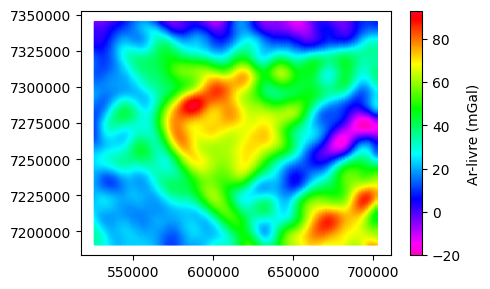

In [93]:
dados = pd.read_csv(arquivo)

#Plotar
plt.figure(figsize=(5, 3))  #tamanho da figura
entrada_fa = plt.scatter(dados.LESTE, dados.NORTE, c=dados.FA, cmap='gist_rainbow_r', s=1)
plt.colorbar(entrada_fa, label="Ar-livre (mGal)") #barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em fornamo "não-científico"
plt.tight_layout()
plt.show()

In [94]:
dados

,LESTE,NORTE,TOPO,FA
0,526228,7191184,876.385132,31.029372
1,526228,7192082,868.486389,31.726894
2,526228,7192980,866.235352,32.363132
3,526228,7193878,874.895874,32.865044
4,526228,7194776,892.414856,33.299569
...,...,...,...,...
33879,702236,7341150,698.855835,12.847243
33880,702236,7342048,680.484741,11.449720
33881,702236,7342946,665.303650,10.326270
33882,702236,7343844,659.274597,9.245908


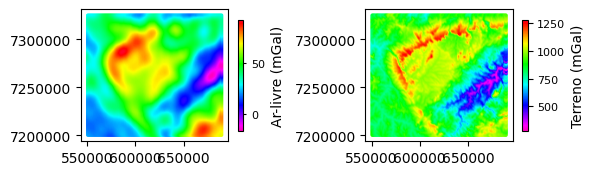

In [95]:
#Etapa opcional - Recortar o dado

N1, N2, E1, E2 = 7200000, 7325000, 550000, 690000 #Coordenadas
regiao_utm22 = (E1, E2, N1, N2)
janela = vd.inside((dados.LESTE, dados.NORTE), regiao_utm22)
dados = dados[janela]

#Plotar mapas
plt.figure(figsize=(6, 4))  #tamanho da figura

plt.subplot(1, 2, 1) #grade de 1 linha e 2 colunas, mapa na coluna 1
mapa_fa = plt.scatter(dados.LESTE, dados.NORTE, c=dados.FA, cmap='gist_rainbow_r', s=1.5)
plt.gca().set_aspect("equal")
colorbar_fa = plt.colorbar(mapa_fa, label="Ar-livre (mGal)", shrink=0.3)
colorbar_fa.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_fa.ax.tick_params(labelsize=8)  # define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em fornamo "não-científico"

plt.subplot(1, 2, 2)
mapa_topo = plt.scatter(dados.LESTE, dados.NORTE, c=dados.TOPO, cmap='gist_rainbow_r', s=1.5)
plt.gca().set_aspect("equal")
colorbar_topo = plt.colorbar(mapa_topo, label="Terreno (mGal)", shrink=0.3)
colorbar_fa.ax.yaxis.set_tick_params(size=2)
colorbar_topo.ax.tick_params(labelsize=8)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

### Organizando os grids de entrada (leste, norte, topografia)

In [96]:
# Adaptação dos dados para entrada em funçãos adiante

# Armazenar coluna com coordenadas norte
col_NORTE = dados['NORTE']
# Remover a coluna do dataframe
dados = dados.drop('NORTE', axis=1)
# Inserir como a primeira coluna
dados.insert(0, 'NORTE', col_NORTE)
# Ordenar dados
dados = dados.sort_values(by=['NORTE','LESTE'], ascending=[True, True])
dados

,NORTE,LESTE,TOPO,FA
4654,7200164,550474,896.584961,21.872118
4826,7200164,551372,888.785156,21.585439
4998,7200164,552270,855.196716,21.295170
5170,7200164,553168,831.465759,20.901054
5342,7200164,554066,822.095032,20.514054
...,...,...,...,...
30765,7324986,686072,900.478333,31.546794
30937,7324986,686970,910.147522,31.656811
31109,7324986,687868,936.895203,31.591885
31281,7324986,688766,936.744385,31.594237


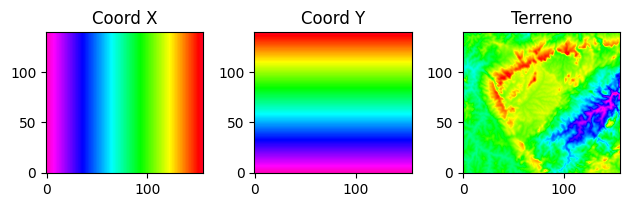

In [97]:
# .to_numpy() converte os valores de dentro da série tipo Pandas em um array NumPy
vetor_LESTE = dados.LESTE.to_numpy()
vetor_NORTE = dados.NORTE.to_numpy()
vetor_TOPO = dados.TOPO.to_numpy()
vetor_FA = dados.FA.to_numpy()

#Elementos a leste e a norte
pontos_LESTE=[]
pontos_NORTE=[]

#Adicionar valores não repetidos
[pontos_LESTE.append(item) for item in vetor_LESTE if not pontos_LESTE.count(item)]
[pontos_NORTE.append(item) for item in vetor_NORTE if not pontos_NORTE.count(item)]

#Salvar número de itens a leste e a norte
n_l = np.size(pontos_LESTE)
n_n = np.size(pontos_NORTE)

#Grid
grid_LESTE, grid_NORTE = np.meshgrid(pontos_LESTE, pontos_NORTE) #mesh
grid_TOPO = np.reshape(vetor_TOPO, (n_n, n_l)) #de 1D para 2D

#Salva as posições dos prismas como array
pontos_LESTE = np.array(pontos_LESTE)
pontos_NORTE = np.array(pontos_NORTE)

plt.subplot(1, 3, 1)
plt.title("Coord X")
plt.imshow(grid_LESTE, cmap='gist_rainbow_r')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
plt.subplot(1, 3, 2)
plt.title("Coord Y")
plt.imshow(grid_NORTE, cmap='gist_rainbow_r')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
plt.subplot(1, 3, 3)
plt.title("Terreno")
plt.imshow(grid_TOPO, cmap='gist_rainbow_r')
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis() #eixo com zero na base
plt.tight_layout()
plt.show()

### Cálculo do efeito gravimétrico

In [98]:
# Efeito gravimétrico - prismas
#BOUGUER EM TERRA
referencia = np.round(np.min(grid_TOPO))-1 #base dos prismas
print ("Mínimo do terreno:", referencia, "\n")
# Densidade dos prismas
contraste = 2670 #para corpos d'agua, usar 1270
densidade = contraste * np.ones_like(grid_LESTE)
print("Grid de contraste de densidade:", densidade)

Mínimo do terreno: 281.0 

Grid de contraste de densidade: [[2670 2670 2670 ... 2670 2670 2670]
 [2670 2670 2670 ... 2670 2670 2670]
 [2670 2670 2670 ... 2670 2670 2670]
 ...
 [2670 2670 2670 ... 2670 2670 2670]
 [2670 2670 2670 ... 2670 2670 2670]
 [2670 2670 2670 ... 2670 2670 2670]]


In [99]:
# Forma dos prismas
prisms_centers = (grid_LESTE, grid_NORTE) #coordenadas dos prismas
altura = np.abs(grid_TOPO) #altura dos prismas
# aqui, o uso do abs() evita que os prismas assumam valores negativos, no caso
# da área conter dados batimétricos


In [100]:
#Modelo de prismas
topo_prisms = hm.prism_layer(
    prisms_centers,
    surface = altura,
    reference = referencia,
    properties = {"density": densidade}
    )

#Calcular o campo gravitacional da camada usando "prism_layer"
coordenadas = (dados.LESTE, dados.NORTE, abs(dados.TOPO))
resultado = topo_prisms.prism_layer.gravity(coordenadas, field="g_z")

#Adicionar dados calculados ao dataframe
dados = dados.assign(EFEITO_GRAV=resultado)
dados

,NORTE,LESTE,TOPO,FA,EFEITO_GRAV
4654,7200164,550474,896.584961,21.872118,48.477602
4826,7200164,551372,888.785156,21.585439,53.298568
4998,7200164,552270,855.196716,21.295170,51.960848
5170,7200164,553168,831.465759,20.901054,50.586160
5342,7200164,554066,822.095032,20.514054,50.083571
...,...,...,...,...,...
30765,7324986,686072,900.478333,31.546794,55.987601
30937,7324986,686970,910.147522,31.656811,56.458281
31109,7324986,687868,936.895203,31.591885,57.929241
31281,7324986,688766,936.744385,31.594237,56.608853


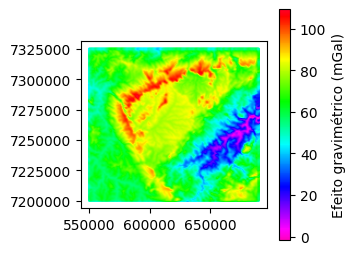

In [102]:
#Exibir mapa do dado calculado
plt.figure(figsize=(3,3))
mapa_calc = plt.scatter(
    dados.LESTE, dados.NORTE, c=dados.EFEITO_GRAV, s=1.2, cmap="gist_rainbow_r")

plt.colorbar(mapa_calc, label="Efeito gravimétrico (mGal)")
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em formato "não-científico"
plt.gca().set_aspect("equal")#mantém as proporções do mapa
plt.show()

In [103]:
# Calcular a Anomalia Bouguer e adicionar ao dataframe
# (-) para dados em terra, (+) para dados de topografia negativa

dados = dados.assign(BOUGUER = dados.FA - dados.EFEITO_GRAV)

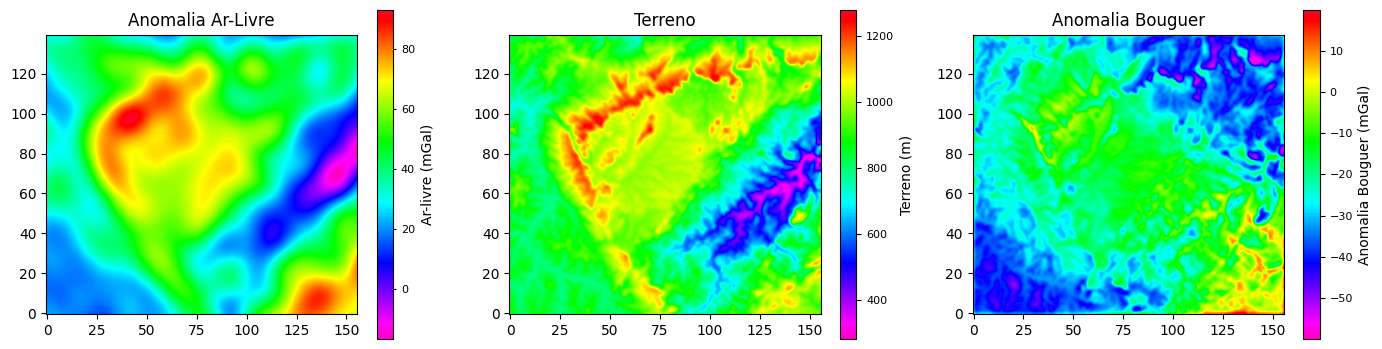

In [104]:
#Plotar mapas
plt.figure(figsize=(14, 5))  #tamanho da figura

#Grid FA e BOUGUER
grid_FA = np.reshape(vetor_FA, (n_n, n_l)) #de 1D para 2D
grid_BOUG = np.reshape(dados.BOUGUER.to_numpy(), (n_n, n_l)) #de 1D para 2D

plt.subplot(1, 3, 1) #grade de 1 linha e 4 colunas
plt.title('Anomalia Ar-Livre')
mapa_fa = plt.imshow(grid_FA, cmap='gist_rainbow_r', interpolation='bilinear')
colorbar_fa = plt.colorbar(mapa_fa, label="Ar-livre (mGal)", shrink=0.7)
colorbar_fa.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_fa.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo y em fornamo "não-científico"
plt.gca().invert_yaxis() #eixo com zero na base

plt.subplot(1, 3, 2)
plt.title('Terreno')
mapa_topo = plt.imshow(grid_TOPO, cmap='gist_rainbow_r', interpolation='bilinear')
colorbar_topo = plt.colorbar(mapa_topo, label="Terreno (m)", shrink=0.7)
colorbar_fa.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_topo.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo em fornamo "não-científico"
plt.gca().invert_yaxis() #eixo com zero na base

plt.subplot(1, 3, 3)
plt.title('Anomalia Bouguer')
mapa_topo = plt.imshow(grid_BOUG, cmap='gist_rainbow_r', interpolation='bilinear')
colorbar_topo = plt.colorbar(mapa_topo, label="Anomalia Bouguer (mGal)", shrink=0.7)
colorbar_fa.ax.yaxis.set_tick_params(size=2)  # tamanho das marcações na barra de cores
colorbar_topo.ax.tick_params(labelsize=8)  # Define o tamanho dos labels da barra de cores
plt.ticklabel_format(style='plain', axis='y')  # valores do eixo em fornamo "não-científico"
plt.gca().invert_yaxis() #eixo com zero na base

plt.tight_layout()

#Salvar figura
plt.savefig('output.png', dpi=300, bbox_inches='tight')

plt.show()



Salvar a saída como arquivo csv

In [105]:
dados.to_csv("grav_boug_py.csv")

Extra - Funções adicionais

In [42]:
#Verificar se o espaçamento do grid é regular
def espacamento_regular(grid):
    # Verificar espacamento nas colunas
    primeira_coluna = grid[:, 0]
    diferenca_colunas = primeira_coluna[1:] - primeira_coluna[:-1]
    if not (diferenca_colunas == diferenca_colunas[0]).all():
        return False
    # Verificar espacamento nas linhas
    primeira_linha = grid[0, :]
    diferenca_linhas = primeira_linha[1:] - primeira_linha[:-1]
    if not (diferenca_linhas == diferenca_linhas[0]).all():
        return False
    return True

#Exemplo:
espacamento_regular(grid_NORTE)

True